In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import gala.potential as gp
import gala.dynamics as gd
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','nature'])
plt.rcParams['text.usetex']=False
import matplotlib.patheffects as patheffects
from uncertainties import ufloat as uf
import statistics
import math
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from linmix import linmix
from scipy.stats import norm

# read Cepheids catalogue from Skowron et al. 2019

In [2]:
file_path = 'Skowron2019_GalClassCephDist.dat'
with open(file_path, 'r') as file:
    data=[line.strip().split() for line in file if line[0]!='#']
datasize=len(data)
data_positive_dist=[[float(a[2]),
                     float(a[3]),
                     float(a[4])/1000,
                     float(a[5])/1000] for a in data if a[4]!='-1']
df_skowron=pd.DataFrame(data_positive_dist,columns=['l','b','dist','dist_err'])
            

In [3]:
#↓ReidのA5モデル
Wo=7.6
Ro=8.15
Zo=0.0055
Uo=10.6
Vo=10.7+236

In [4]:
gc_frame = coord.Galactocentric(
    galcen_distance=Ro * u.kpc, galcen_v_sun=(Uo, Vo, Wo)*(u.km/u.s), z_sun=Zo * u.kpc
    )
c=coord.SkyCoord(l=df_skowron['l'],b=df_skowron['b'],distance=df_skowron['dist'],
                 unit=('deg','deg','kpc'),frame='galactic')
c_gc=c.transform_to(gc_frame)

df_skowron['x']=c_gc.x.value
df_skowron['y']=c_gc.y.value
df_skowron['z']=c_gc.z.value
df_skowron['r']=np.sqrt(df_skowron['x']**2+df_skowron['y']**2)

In [5]:
df_skowron=df_skowron[(df_skowron['r']<20)&(df_skowron['dist_err']/df_skowron['dist']<0.05)&(np.abs(df_skowron['z'])<3)]

# read Gaia DR3 data 

In [7]:
file_path = 'path/to/data'
df_gaia=pd.read_table(file_path,delimiter=' ')

In [10]:
# crossmatch the data
for i in df_skowron.index:
    mini_index=df_gaia[(np.abs(df_skowron['l'][i]-df_gaia['l'])<0.001)&(np.abs(df_skowron['b'][i]-df_gaia['b'])<0.001)].index
    df_gaia.loc[mini_index,'dist']=df_skowron['dist'][i]
    df_gaia.loc[mini_index,'dist_error']=df_skowron['dist_err'][i]

## coordinate transform, using 'uncerntainties' package

In [11]:
RA=df_gaia['ra']*math.pi/180
DEC=df_gaia['dec']*math.pi/180

B=df_gaia['b']*math.pi/180
L=df_gaia['l']*math.pi/180

dist_uf=np.array([uf(df_gaia['dist'][i],df_gaia['dist_error'][i]) for i in df_gaia.index])


In [12]:
x=dist_uf*np.cos(B)*np.cos(L)-Ro
y=dist_uf*np.cos(B)*np.sin(L)
z=dist_uf*np.sin(B)-Zo
r=(x**2+y**2)**(1/2)

df_gaia['x']=[i.n for i in x]
df_gaia['x_error']=[i.s for i in x]
df_gaia['y']=[i.n for i in y]
df_gaia['y_error']=[i.s for i in y]
df_gaia['z']=[i.n for i in z]
df_gaia['z_error']=[i.s for i in z]

df_gaia['r']=[i.n for i in r]
df_gaia['r_error']=[i.s for i in r]

In [13]:
cos=-df_gaia['x']/df_gaia['r']
sin=df_gaia['y']/df_gaia['r']

df_gaia['phi']=np.arccos(cos)*u.rad.to('deg')
df_gaia.loc[(df_gaia['y']<0),'phi']=-df_gaia['phi']

In [14]:
G = np.array([[-0.0548755604162154, -0.8734370902348850, -0.4838350155487132]
              , [0.4941094278755837, -0.4448296299600112, 0.7469822444972189]
              , [-0.8676661490190047, -0.1980763734312015, 0.4559837761750669]])
pm_G=[]
for i in df_gaia.index:
    PE=np.array([[-np.sin(RA[i])],[np.cos(RA[i])],[0]])
    QE=np.array([[-np.cos(RA[i])*np.sin(DEC[i])],[-np.sin(RA[i])*np.sin(DEC[i])],[np.cos(DEC[i])]])
    PG=G.T@np.array([[-np.sin(L[i])],[np.cos(L[i])],[0]])
    QG=G.T@np.array([[-np.cos(L[i])*np.sin(B[i])],[-np.sin(L[i])*np.sin(B[i])],[np.cos(B[i])]])

    pm_G.append(
        np.concatenate([PG.T,QG.T], 0)@np.concatenate([PE,QE], 1)@np.array([[uf(df_gaia['pmra'][i],df_gaia['pmra_error'][i])],[uf(df_gaia['pmdec'][i],df_gaia['pmdec_error'][i])]])
    )
    #pm_G[i][0][0]がpm_l_cosb
    #pm_G[i][1][0]がpm_b
    #gaiadr3.galactic.と確認済み。

In [15]:
V_pm_b=np.array(pm_G).reshape(1440,2).T[1]*4.74*dist_uf*np.sin(B)
vr=np.array([uf(df_gaia['radial_velocity'][i],df_gaia['radial_velocity_error'][i]) for i in df_gaia.index])*np.cos(df_gaia['b']*math.pi/180)-V_pm_b
vt=np.array(pm_G).reshape(1440,2).T[0]*4.74*dist_uf

vx=vr*np.cos(L)-vt*np.sin(L)+Uo
vy=vr*np.sin(L)+vt*np.cos(L)+Vo

Vrad=-cos*vx+sin*vy
Vphi=cos*vy+sin*vx

Vz=np.array(pm_G).reshape(1440,2).T[1]*4.74*dist_uf*np.cos(B)+np.array([uf(df_gaia['radial_velocity'][i],df_gaia['radial_velocity_error'][i]) for i in df_gaia.index])*np.sin(B)+Wo


In [16]:
df_gaia['Vrad']=[i.n for i in Vrad]
df_gaia['Vrad_error']=[i.s for i in Vrad]

df_gaia['Vphi']=[i.n for i in Vphi]
df_gaia['Vphi_error']=[i.s for i in Vphi]

df_gaia['Vz']=[i.n for i in Vz]
df_gaia['Vz_error']=[i.s for i in Vz]

In [17]:
lz=r*Vphi
df_gaia['Lz']=[i.n for i in lz]
df_gaia['Lz_error']=[i.s for i in lz]

In [18]:
df=df_gaia[(np.abs(df_gaia['Vz'])<50) & (np.abs(df_gaia['Vrad'])<50) & (df_gaia['Vphi']>170) & (df_gaia['Vphi']<270) &(df_gaia['radial_velocity_error']<10)]

# compute eccentricities using gala

In [19]:
# scaling a potential aligned with the Cepheids' actual rotation velocity
solar_position=np.array([Ro,0,Zo])*u.kpc
mw_potential = gp.MilkyWayPotential2022()

In [20]:
scaled_potential = gp.CCompositePotential(
    disk=gp.MN3ExponentialDiskPotential(
        m=mw_potential['disk'].parameters['m'],
        h_R=mw_potential['disk'].parameters['h_R'] *Ro/8.122,
        h_z=mw_potential['disk'].parameters['h_z'] *Zo/0.025,
        units=mw_potential['disk'].units
    ),
    halo=gp.NFWPotential(
        m=mw_potential['halo'].parameters['m'],
        r_s=mw_potential['halo'].parameters['r_s']  *Ro/8.12,
        a=mw_potential['halo'].parameters['a'],
        b=mw_potential['halo'].parameters['b'],
        c=mw_potential['halo'].parameters['c'],
        units=mw_potential['halo'].units
    ),
    bulge=gp.HernquistPotential(
        m=mw_potential['bulge'].parameters['m'],
        c=mw_potential['bulge'].parameters['c'],
        units=mw_potential['bulge'].units
    ),
    nucleus=gp.HernquistPotential(
        m=mw_potential['nucleus'].parameters['m'],
        c=mw_potential['nucleus'].parameters['c'],
        units=mw_potential['nucleus'].units
    )
)


In [21]:
vc = scaled_potential.circular_velocity(solar_position)
print(vc)

[230.49233441] km / s


In [22]:
def rotationspeed(Lz,df):
    return np.average(df[np.abs(df['r']*df['Vphi']-Lz)<200]['Vphi'])

In [23]:
target_vc=np.average([rotationspeed(Lz,df) for Lz in df['Lz'] if np.abs(Lz/rotationspeed(Lz,df)-Ro)<0.5])
print(target_vc)
scaling=(target_vc/vc)[0].value

228.83230171095065


In [25]:
scaled_potential = gp.CCompositePotential(
    disk=gp.MN3ExponentialDiskPotential(
        m=mw_potential['disk'].parameters['m']*scaling**2,
        h_R=mw_potential['disk'].parameters['h_R'] *Ro/8.122,
        h_z=mw_potential['disk'].parameters['h_z'] *Zo/0.025,
        units=mw_potential['disk'].units
    ),
    halo=gp.NFWPotential(
        m=mw_potential['halo'].parameters['m']*scaling**2,
        r_s=mw_potential['halo'].parameters['r_s']  *Ro/8.12,
        a=mw_potential['halo'].parameters['a'],
        b=mw_potential['halo'].parameters['b'],
        c=mw_potential['halo'].parameters['c'],
        units=mw_potential['halo'].units
    ),
    bulge=gp.HernquistPotential(
        m=mw_potential['bulge'].parameters['m']*scaling**2,
        c=mw_potential['bulge'].parameters['c'],
        units=mw_potential['bulge'].units
    ),
    nucleus=gp.HernquistPotential(
        m=mw_potential['nucleus'].parameters['m']*scaling**2,
        c=mw_potential['nucleus'].parameters['c'],
        units=mw_potential['nucleus'].units
    )
)


In [26]:
vc_adjusted = scaled_potential.circular_velocity(solar_position)

In [31]:
c=coord.SkyCoord(ra=np.array(df_gaia['ra'])*u.deg,
                 dec=np.array(df_gaia['dec'])*u.deg,
                 distance=np.array(df_gaia['dist'])*u.kpc,
                 pm_ra_cosdec=np.array(df_gaia['pmra'])*u.mas/u.year,
                 pm_dec=np.array(df_gaia['pmdec'])*u.mas/u.year,
                 radial_velocity=np.array(df_gaia['radial_velocity'])*u.km/u.s)

gc_frame = coord.Galactocentric(
    galcen_distance=Ro * u.kpc, galcen_v_sun=(Uo, Vo, Wo)*(u.km/u.s), z_sun=Zo * u.kpc
)
c_gc=c.transform_to(gc_frame)

In [32]:
cep_w0 = gd.PhaseSpacePosition(c_gc.data)
cep_orbit = scaled_potential.integrate_orbit(cep_w0, t=np.linspace(0,4000,8000)*u.Myr)

In [33]:
df_gaia['ecc']=cep_orbit.eccentricity()

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [34]:
# get data used in Funakoshi et al. 2024
df=df_gaia[(np.abs(df_gaia['Vz'])<50) & (np.abs(df_gaia['Vrad'])<50) & (df_gaia['Vphi']>170) & (df_gaia['Vphi']<270) &(df_gaia['radial_velocity_error']<10) & (df_gaia['ecc']<0.2)]

In [35]:
df['Vphi-rot']=df['Vphi']-rotationspeed(df['Lz'],df)
df['Rg']=df['Lz']/np.array([rotationspeed(df['Lz'],df)])

/tmp/ipykernel_22320/3409730810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vphi-rot']=df['Vphi']-rotationspeed(df['Lz'],df)
/tmp/ipykernel_22320/3409730810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rg']=df['Lz']/np.array([rotationspeed(df['Lz'],df)])


# plots

In [37]:
def makefig(size=[8,8],aspect=0,bkgcolor='white'):
    fig,ax=plt.subplots()
    fig.set_size_inches(size[0],size[1])
    ax.set_facecolor(bkgcolor)
    if aspect==1:
        ax.set_aspect(1)
        
def closefig(savename=""):
    if savename!="":
        plt.savefig(savename+".pdf",bbox_inches='tight')
    plt.show()

In [38]:
arm_shape_dict={'out':lambda ph,dR:[(12.24+dR)*np.exp(-(ph[i]-18)*math.pi/180*np.tan(3*u.deg)).value for i in range(len(ph)) if ph[i]<18]+[(12.24+dR)*np.exp(-(ph[i]-18)*math.pi/180*np.tan(9.4*u.deg)).value for i in range(len(ph)) if ph[i]>18],
                'per':lambda ph,dR:[(9.57+dR)*np.exp(-(ph[i]-32.7)*math.pi/180*np.tan(3.9*u.deg)).value for i in range(len(ph)) if ph[i]<32.7]+[(9.57+dR)*np.exp(-(ph[i]-32.7)*math.pi/180*np.tan(19.9*u.deg)).value for i in range(len(ph)) if ph[i]>32.7],
                'other':lambda ph,R:(R)*np.exp(-(ph)*math.pi/180*np.tan(4*u.deg)).value}

arm_phi_dict={'out':np.linspace(-16,71),
                   'per':np.linspace(-28,51),
                   'other':np.linspace(-50,30)}

arm_color={'out':'red','per':'blue','other':'black'}


def plotarms(armname,dR=0,ls='solid',lw=2,zorder=1,log=False):
    ph=arm_phi_dict[armname]
    R=arm_shape_dict[armname](ph,dR)
    if log:
        x=ph
        y=np.log(R)
    else:
        x=R*np.sin(ph*u.deg)
        y=R*np.cos(ph*u.deg)
    plt.plot(x,y,color=arm_color[armname],ls=ls,lw=lw,zorder=zorder)

In [39]:
def Rprime_log(R_s,phi_s,pit=4):
    return np.log(R_s/(np.exp(-phi_s*math.pi/180*np.tan(pit*u.deg))))

In [40]:
# R', explained in Section 2.2
df['rprime']=Rprime_log(df['r'],df['phi'])

/tmp/ipykernel_22320/3996588327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rprime']=Rprime_log(df['r'],df['phi'])


In [41]:
df_perseus=df[(df['phi']>-50)&(df['phi']<30)&(df['rprime']>2.25)&(df['rprime']<2.35)]
df_outer=df[(df['phi']>-50)&(df['phi']<30)&(df['rprime']>2.5)&(df['rprime']<2.6)]

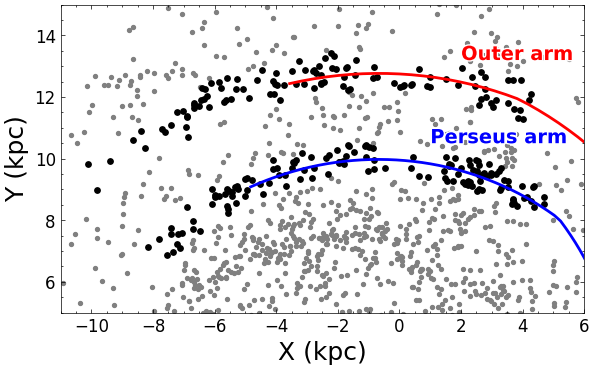

In [42]:
makefig([7,4],aspect=1)
plt.scatter(df['y'],-df['x'],color='gray',s=8)
plt.scatter(df_outer['y'],-df_outer['x'],color='black',s=15)
plt.scatter(df_perseus['y'],-df_perseus['x'],color='black',s=15)

plotarms('out',dR=0.3)
plotarms('per')

plt.text(2,13.2,"Outer arm",color='red',fontsize=14,weight='bold',path_effects=[patheffects.withStroke(linewidth=2,foreground='white',capstyle='round')])
plt.text(1,10.5,"Perseus arm",color='blue',fontsize=14,weight='bold',path_effects=[patheffects.withStroke(linewidth=2,foreground='white',capstyle='round')])
plt.xlim(-11,6)
plt.ylim(5,15)
plt.xlabel("X (kpc)",fontsize=18)
plt.ylabel("Y (kpc)",fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

closefig()

In [43]:
lz_rc=np.linspace(1000,4000,1000)
vc_rc=np.array([rotationspeed(j,df) for j in lz_rc])
rg_rc=lz_rc/vc_rc

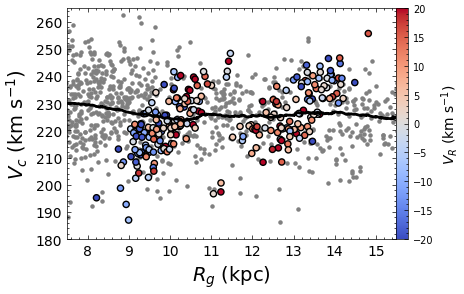

In [44]:
makefig([5,3])
plt.plot(rg_rc,vc_rc,color='black',lw=2)

plt.scatter(df['Rg'],df['Vphi'],color='gray',s=5)

plt.scatter(df_perseus['Rg'],df_perseus['Vphi'],c=df_perseus['Vrad'],
            cmap='coolwarm',edgecolors='black',s=20)
plt.clim(-20,20)

plt.scatter(df_outer['Rg'],df_outer['Vphi'],c=df_outer['Vrad'],
            cmap='coolwarm',edgecolors='black',s=20)
plt.clim(-20,20)

plt.colorbar(pad=0).set_label(r'$V_R$ (km s$^{-1}$)',fontsize=10)
plt.xlabel(r'$R_g$ (kpc)',fontsize=14)
plt.ylabel(r'$V_c$ (km s$^{-1}$)',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(7.5,15.5)
plt.ylim(180,265)
closefig()


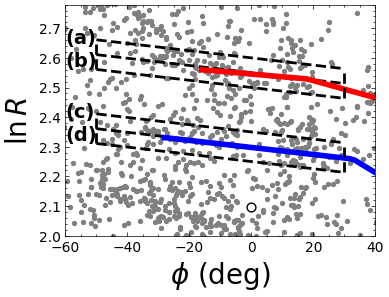

In [45]:
makefig([4,3])
plt.subplots_adjust(wspace=0.3, hspace=0.05)

plt.scatter(df['phi'],np.log(df['r']),c='gray',s=8,zorder=1)
plotarms('other',np.exp(2.5),log=True,ls='--')
plotarms('other',np.exp(2.55),log=True,ls='--')
plotarms('other',np.exp(2.6),log=True,ls='--')

plt.vlines(-50,np.log(arm_shape_dict['other'](-50,np.exp(2.5))),
           np.log(arm_shape_dict['other'](-50,np.exp(2.6))),
           lw=2,color='black',ls='--')
plt.vlines(30,np.log(arm_shape_dict['other'](30,np.exp(2.5))),
           np.log(arm_shape_dict['other'](30,np.exp(2.6))),
           lw=2,color='black',ls='--')

plotarms('other',np.exp(2.25),log=True,ls='--')
plotarms('other',np.exp(2.3),log=True,ls='--')
plotarms('other',np.exp(2.35),log=True,ls='--')

plt.vlines(-50,np.log(arm_shape_dict['other'](-50,np.exp(2.25))),
           np.log(arm_shape_dict['other'](-50,np.exp(2.35))),
           lw=2,color='black',ls='--')
plt.vlines(30,np.log(arm_shape_dict['other'](30,np.exp(2.25))),
           np.log(arm_shape_dict['other'](30,np.exp(2.35))),
           lw=2,color='black',ls='--')

plotarms('out',0.3,log=True,lw=4)
plotarms('per',log=True,lw=4)

plt.text(-60,2.65,"(a)",fontsize=14,weight='bold')
plt.text(-60,2.57,"(b)",fontsize=14,weight='bold')
plt.text(-60,2.4,"(c)",fontsize=14,weight='bold')
plt.text(-60,2.32,"(d)",fontsize=14,weight='bold')

plt.scatter(0,np.log(Ro),s=40,color="white",ec="black")

plt.ylabel(r"$\ln R$",fontsize=20)
plt.ylim(2,2.78)
plt.xlim(-60,40)
plt.xlabel(r"$\phi$ (deg)",fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

closefig()

In [46]:
df_outer_leading=df_outer[df_outer['rprime']>2.55]
df_outer_trailing=df_outer[df_outer['rprime']<2.55]

df_perseus_leading=df_perseus[df_perseus['rprime']>2.3]
df_perseus_trailing=df_perseus[df_perseus['rprime']<2.3]

In [47]:
def vertex_ave(df):
    U=df['Vrad']
    V=df['Vphi-rot']
    gyouretsu=np.cov(U,V)
    bunsanU=gyouretsu[0][0]
    bunsanV=gyouretsu[1][1]
    kyobunsanUV=gyouretsu[0][1]
    if bunsanU>bunsanV:
        return 0.5*np.arctan(2*(kyobunsanUV)/(bunsanU-bunsanV))
    else:
        return 0.5*np.arctan(2*(kyobunsanUV)/(bunsanU-bunsanV))+np.sign(kyobunsanUV)*math.pi/2

In [48]:
def jack(df,func=vertex_ave,cond="both"):
    jack_sample=[]    
    for i in df.index:
        df_wo_i=df[df.index!=i]
        jack_sample.append(func(df_wo_i))
    jack_ave=np.nanmean(jack_sample)
    
    jack_esti=len(df.index)*func(df)-(len(df.index)-1)*jack_ave
    jack_err_esti=np.sqrt(len(df.index)-1)*np.nanstd(jack_sample)
    if cond=="both":
        return jack_esti,jack_err_esti 
    else:
        return jack_err_esti  

In [49]:
lv_tan_a,er_a=jack(df_outer_leading)
lv_tan_b,er_b=jack(df_outer_trailing)
lv_tan_c,er_c=jack(df_perseus_leading)
lv_tan_d,er_d=jack(df_perseus_trailing)

In [50]:
def vrvphiplot(df,rprime):
    med=statistics.median(df['Lz'])

    plt.errorbar(df['Vrad'],df['Vphi-rot'],
                xerr=df['Vrad_error'],yerr=df['Vphi_error'],
                fmt='.',zorder=1,lw=0.5,color='black',capsize=2)
    plt.scatter(df['Vrad'],df['Vphi-rot'],
                c=df['Lz'],
                s=20,label="Leading ("+str(round(rprime,2))+r"< $R'$ <"+str(round(rprime+0.05,2))+")"
                    ,cmap="coolwarm_r",edgecolors="black"
                    ,zorder=2)
    plt.clim(med-400,med+400)
    

In [51]:
col="black"
ls="--"
x_ran=np.linspace(-43,38)

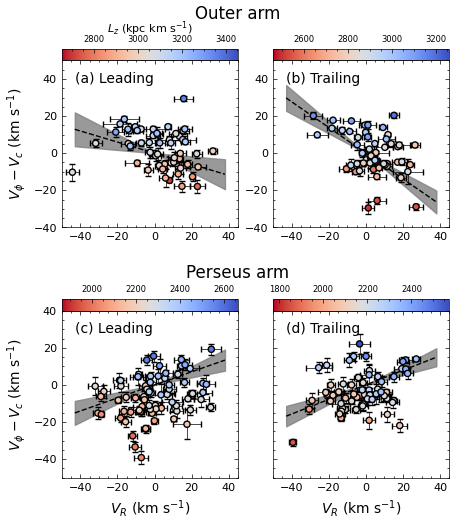

In [52]:
fig=plt.figure(figsize=(5,6.5))

ax1=plt.subplot(221)
ax1.set_aspect(True)
ax1.set_title('Outer arm',x=1,y=1.2,fontsize=12)
plt.plot(x_ran,x_ran*lv_tan_a,color=col,ls=ls)
plt.fill_between(x_ran, x_ran*(lv_tan_a-er_a), x_ran*(lv_tan_a+er_a), color="gray", alpha=0.8)

vrvphiplot(df_outer_leading,2.55)
clb=plt.colorbar(location="top",pad=0,aspect=15)
clb.ax.tick_params(labelsize=6) 
clb.ax.set_title(label=r"$L_z$ (kpc km $\mathrm{s^{-1}}$)",fontsize=8,y=1.7)

plt.ylabel(r"$V_{\phi}-V_c$ (km $\mathrm{s^{-1}}$)",fontsize=10)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.ylim(-40,50)
plt.xlim(-50,45)

plt.text(-43,38,"(a) "+"Leading",fontsize=10)


ax2=plt.subplot(222)
ax2.set_aspect(True)
plt.plot(x_ran,x_ran*lv_tan_b,color=col,ls=ls)
plt.fill_between(x_ran, x_ran*(lv_tan_b-er_b), x_ran*(lv_tan_b+er_b), color="gray", alpha=0.8)

vrvphiplot(df_outer_trailing,2.5)
clb=plt.colorbar(location="top",pad=0,aspect=15)
clb.ax.tick_params(labelsize=6) 

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.ylim(-40,50)
plt.xlim(-50,45)

plt.text(-43,38,"(b) "+"Trailing",fontsize=10)

ax3=plt.subplot(223)
ax3.set_aspect(True)
ax3.set_title('Perseus arm',x=1, y=1.15,fontsize=12)
plt.plot(x_ran,x_ran*lv_tan_c,color=col,ls=ls)
plt.fill_between(x_ran, x_ran*(lv_tan_c-er_c), x_ran*(lv_tan_c+er_c), color="gray", alpha=0.8)

vrvphiplot(df_perseus_leading,2.3)
clb=plt.colorbar(location="top",pad=0,aspect=15)
clb.ax.tick_params(labelsize=6) 

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.ylabel(r"$V_{\phi}-V_c$ (km $\mathrm{s^{-1}}$)",fontsize=10)
plt.xlabel(r"$V_R$ (km $\mathrm{s^{-1}}$)",fontsize=10)

plt.ylim(-50,40)
plt.xlim(-50,45)
plt.text(-43,28,"(c) "+"Leading",fontsize=10)


ax4=plt.subplot(224)
ax4.set_aspect(True)
plt.plot(x_ran,x_ran*lv_tan_d,color=col,ls=ls)
plt.fill_between(x_ran, x_ran*(lv_tan_d-er_d), x_ran*(lv_tan_d+er_d), color="gray", alpha=0.8)

vrvphiplot(df_perseus_trailing,2.25)
clb=plt.colorbar(location="top",pad=0,aspect=15)
clb.ax.tick_params(labelsize=6) 


plt.xticks(fontsize=8)
plt.xlabel(r"$V_R$ (km $\mathrm{s^{-1}}$)",fontsize=10)

plt.ylim(-50,40)
plt.xlim(-50,45)
plt.yticks(color="None")
plt.text(-43,28,"(d) "+"Trailing",fontsize=10)


plt.subplots_adjust(wspace=0.2, hspace=0.0)
closefig()

In [53]:
left=np.flip(np.linspace(17,27,21))/10
right=left+0.05
xlis=((left+right)/2)

In [54]:
df_lim_phi=df[(df['phi']<30)&(df['phi']>-50)]

vd_list=[]
vd_error_list=[]
num_list=[]
for le in left:
    df_for_calc=df_lim_phi[(df_lim_phi['rprime']>le)&(df_lim_phi['rprime']<le+0.05)]
    vd,vd_err=jack(df_for_calc,func=vertex_ave)
    vd_list.append(vertex_ave(df_for_calc))
    vd_error_list.append(vd_err)
    num_list.append(len(df_for_calc.index))

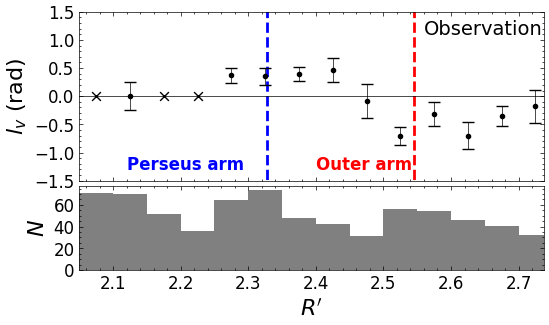

In [55]:
figure = plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.05)
gs_master=GridSpec(nrows=6, ncols=1, height_ratios=[2,1,0.5,2,1,0.5])

gs_1 = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_master[0, 0])
ax1 = figure.add_subplot(gs_1[:, :])
ax1.patch.set_visible(False)

for i in ['out','per']:
    plt.vlines(np.log(arm_shape_dict[i]([0],0.3)),-2,2,color=arm_color[i],ls='--',lw=2)

ax1.errorbar(
    [xlis[i] for i in range(len(xlis)) if vd_error_list[i]<1]
    ,[vd_list[i] for i in range(len(xlis)) if vd_error_list[i]<1]
    ,yerr=[vd_error_list[i] for i in range(len(xlis)) if vd_error_list[i]<1]
    ,fmt="o",markersize=3,capsize=4,color="black",lw=0.5,label="vertex deviation",zorder=3,alpha=1)


plt.scatter(
    [xlis[i] for i in range(len(xlis)) if vd_error_list[i]>1]
    ,[0 for i in range(len(xlis)) if vd_error_list[i]>1]
    ,marker="x",color="black",s=40
)

plt.text(2.12,-1.3,'Perseus arm',color=arm_color['per'],fontsize=12,weight='bold')
plt.text(2.4,-1.3,'Outer arm',color=arm_color['out'],fontsize=12,weight='bold')
plt.text(2.56,1.1,'Observation',color='black',fontsize=14)

plt.hlines(0,1.7,2.8,color="black",lw=0.5)
plt.ylim(-1.5,1.5)
plt.xlim(2.05,2.738)
plt.xticks(color="None")
plt.yticks(fontsize=12)
plt.ylabel(r"$l_v$ (rad)",fontsize=16)

gs_4 = GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=gs_master[1, :])
ax = figure.add_subplot(gs_4[:, :])

plt.bar(xlis,num_list,width=0.05,color="gray")
plt.xlim(2.05,2.738)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel(r"$N$",fontsize=16)
plt.xlabel(r"$R'$",fontsize=16)


closefig()

In [56]:
def fit_linmix(df):
    lm = linmix.LinMix(df['Lz'], df['Vrad'], xsig=df['Lz_error'], ysig=df['Vrad_error'], nchains=8, seed=42, K=2)
    lm.run_mcmc(silent=True)
    return lm.chain['alpha'], lm.chain['beta'], lm.chain['corr']

In [57]:
alpha_per,beta_per,cor_per=fit_linmix(df_perseus)
alpha_out,beta_out,cor_out=fit_linmix(df_outer)

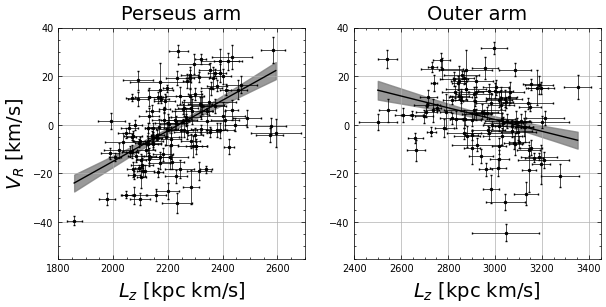

In [58]:
plt.figure(figsize=(7,3))
ax=plt.subplot(121)

plt.errorbar(df_perseus['Lz'],df_perseus['Vrad'],
             xerr=df_perseus['Lz_error'],yerr=df_perseus['Vrad_error'],
             c="black",fmt=".",capsize=1,lw=0.5,zorder=2)
x_fit=np.linspace(min(df_perseus['Lz']),max(df_perseus['Lz']))

y_fit = lambda x: x[2] + x[1]*x[0]

realisations = y_fit([x_fit, beta_per[:, None], alpha_per[:, None]])
bounds = np.percentile(realisations, 100 * norm.cdf([-1, 1]), axis=0)
plt.fill_between(x_fit, bounds[0, :], bounds[1, :], color="gray", alpha=0.8)
p2 = plt.plot(x_fit, y_fit([x_fit, beta_per.mean(), alpha_per.mean()]), ls="-", lw=1, marker="", c="k",zorder=3)

plt.grid()
plt.xlabel(r"$L_z$ [kpc km/s]",fontsize=14)
plt.ylabel(r"$V_R$ [km/s]",fontsize=14)
plt.xlim(1800,2700)
plt.ylim(-55,40)

ax.set_title("Perseus arm",fontsize=14)




ax=plt.subplot(122)

plt.errorbar(df_outer['Lz'],df_outer['Vrad'],
             xerr=df_outer['Lz_error'],yerr=df_outer['Vrad_error'],
             c="black",fmt=".",capsize=1,lw=0.5,zorder=2)

plt.xlim(2400,3450)
x_fit=np.linspace(min(df_outer['Lz']),max(df_outer['Lz']))
realisations = y_fit([x_fit, beta_out[:, None], alpha_out[:, None]])
bounds = np.percentile(realisations, 100 * norm.cdf([-1, 1]), axis=0)
plt.fill_between(x_fit, bounds[0, :], bounds[1, :], color="gray", alpha=0.8)
p2 = plt.plot(x_fit, y_fit([x_fit, beta_out.mean(), alpha_out.mean()]), ls="-", lw=1, marker="", c="k",zorder=3)


plt.subplots_adjust(wspace=0.2, hspace=0.25)
plt.grid()
plt.xlabel(r"$L_z$ [kpc km/s]",fontsize=14)
plt.ylim(-55,40)
ax.set_title("Outer arm",fontsize=14)

closefig()